# Load data

In [1]:
import numpy as np

fast_model_IND_test_activations = np.load("nighttime_ai_fast_model_fast_data_activations.npy")
fast_model_OOD_activations = np.load("nighttime_ai_fast_model_slow_data_activations.npy")
slow_model_OOD_activations = np.load("nighttime_ai_slow_model_fast_data_activations.npy")
slow_model_IND_test_activations = np.load("nighttime_ai_slow_model_slow_data_activations.npy")

[d.shape for d in (fast_model_IND_test_activations, fast_model_OOD_activations, slow_model_OOD_activations, slow_model_IND_test_activations)]

[(19250, 256), (20304, 256), (19250, 256), (20304, 256)]

# Find N for Kmeans

In [178]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

d = dict()


def f(name, data, name_kmeans):
    inertias = {}
    for n in range(2, 10):
        model = KMeans(n_clusters=n, random_state=0).fit(data)
        inertias[n] = model.inertia_
    name_kmeans[name] = inertias


f('fast_model_IND_test_activations', fast_model_IND_test_activations, d)
f('fast_model_OOD_activations', fast_model_OOD_activations, d)
f('slow_model_OOD_activations', slow_model_OOD_activations, d)
f('slow_model_IND_test_activations', slow_model_IND_test_activations, d)
d

{'fast_model_IND_test_activations': {2: 706000.6734387488,
  3: 643626.2081278247,
  4: 590755.6585162741,
  5: 537179.360932007,
  6: 486165.4933320271,
  7: 451912.98422376515,
  8: 406405.98202567996,
  9: 377727.1888688636},
 'fast_model_OOD_activations': {2: 426732.60426765773,
  3: 310114.508472314,
  4: 234827.46010090114,
  5: 204188.27632092673,
  6: 175433.4210965248,
  7: 154475.3348290607,
  8: 143182.5337736251,
  9: 133025.0009478526},
 'slow_model_OOD_activations': {2: 262966.2089589669,
  3: 201076.9929443689,
  4: 172964.82951241356,
  5: 152451.21239528988,
  6: 139998.05405584382,
  7: 131132.99718189723,
  8: 122607.94636912648,
  9: 115422.54511075265},
 'slow_model_IND_test_activations': {2: 918867.3595885925,
  3: 830132.5798754117,
  4: 765439.3431139563,
  5: 697115.3116521599,
  6: 644799.423506899,
  7: 584551.9750577608,
  8: 523594.78361474373,
  9: 476704.9709672637}}

65621.4617103936
27843.42405951348
20290.949789510305
85018.83980276232


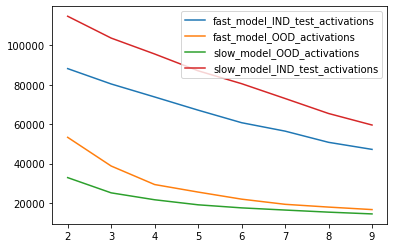

In [189]:

for name, data in d.items():
    data = {k: v for k, v in data.items()}
    average_inertia_over_samples = np.array(list(data.values())) / len(data.values())
    plt.plot(data.keys(), average_inertia_over_samples, label=name)
    print(average_inertia_over_samples.mean())
plt.legend()

# Clustering with N=3

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

fast_model_IND_train = fast_model_IND_test_activations[:9500, :]
fast_model_IND_test = fast_model_IND_test_activations[9500:9500 + 9500, :]

fast_model_IND_train.shape, fast_model_IND_test.shape

((9500, 256), (9500, 256))

# Compare train & test & OOD inertias

In [14]:
N = 3

model = KMeans(n_clusters=N, random_state=0)
train_labels = model.fit_predict(fast_model_IND_train)

def inertia(model, labels, data):
    return np.square(model.cluster_centers_[labels] - data).sum() / len(data)

# test my inertia function
train_inertia = inertia(model, train_labels, fast_model_IND_train)
model.inertia_/len(fast_model_IND_train), train_inertia


(33.59904138756189, 33.59904138756186)

In [15]:
test_labels = model.predict(fast_model_IND_test)
OOD_labels = model.predict(fast_model_OOD_activations)
inertia(model, test_labels, fast_model_IND_test), inertia(model, OOD_labels, fast_model_OOD_activations)


(33.28601068908614, 55.336895814074985)

# How are the samples clustered in these datasets?

In [8]:
import pandas as pd

df = pd.DataFrame(np.array([train_labels, test_labels, OOD_labels]).T, columns=['train', 'test', 'ood'])
pd.DataFrame(df.train.value_counts()).merge(df.test.value_counts(), how='outer', right_index=True, left_index=True).merge(df.ood.value_counts(), right_index=True, left_index=True, how='outer').fillna(0).astype(int)

train  test   ood
0    688   747     0
1   7325  7194  9497
2    796   930     0
3    691   629     3

# How much do clusters match ground truth angle classes?

In [9]:
fast_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = fast_gt[:9500]
test_gt = fast_gt[9500:9500 + 9500]
fast_gt.shape, train_gt.shape, test_gt.shape

((19250,), (9500,), (9500,))

In [10]:
slow_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = slow_gt[:9500]
test_gt = slow_gt[9500:9500 + 9500]
slow_gt.shape, train_gt.shape, test_gt.shape

((20304,), (9500,), (9500,))

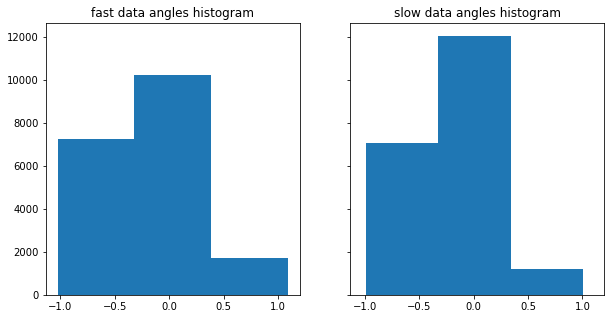

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex='all', sharey='all')

axs.flat[0].hist(fast_gt, bins=3)
axs.flat[0].set_title('fast data angles histogram')
axs.flat[1].hist(slow_gt, bins=3)
axs.flat[1].set_title('slow data angles histogram')
plt.show()

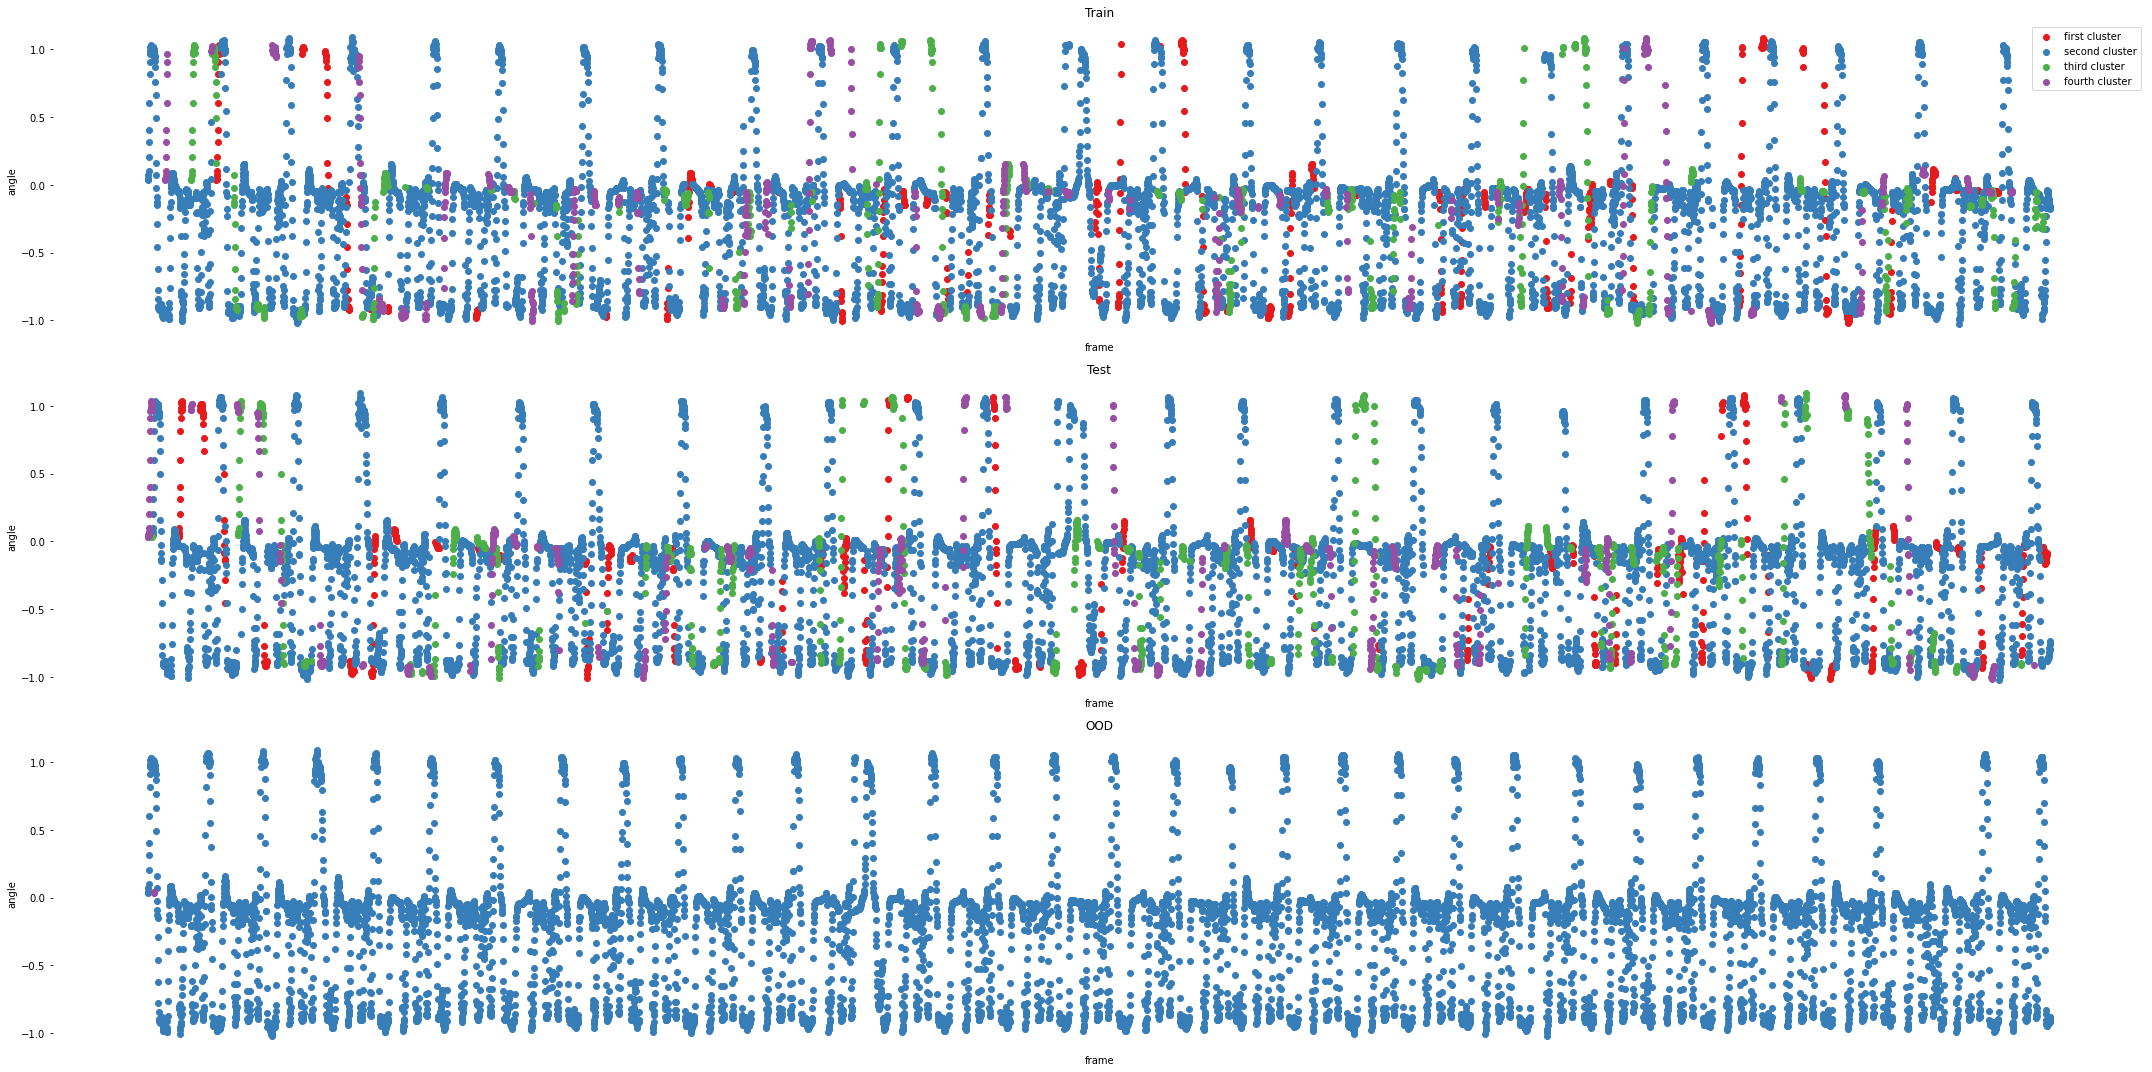

In [14]:
import matplotlib as mpl
cmap = mpl.cm.Set1

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(30, 15), sharex='all', sharey='all')

clustermap = {0: 'first', 1: 'second', 2: 'third', 3: 'fourth'}

for ax, labels in zip(axs.flat, [train_labels, test_labels, OOD_labels]):
    for n in range(N):
        labels_ = labels[labels == n]
        ax.scatter(np.array(list(range(len(labels))))[labels == n], fast_gt[:len(labels_)], color=cmap(n), label=f'{clustermap[n]} cluster')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set(ylabel='angle', xlabel='frame')

axs[0].legend()
axs[0].set_title('Train')
axs[1].set_title('Test')
axs[2].set_title('OOD')
fig.tight_layout()

# assign angles to 3 classes

In [15]:

fast_clazz = np.zeros(len(fast_gt))

fast_clazz[fast_gt < -0.2] = -1
fast_clazz[fast_gt >= -0.2] = 0
fast_clazz[fast_gt > 0.2] = 1

slow_clazz = np.zeros(len(slow_gt))

slow_clazz[slow_gt < -0.2] = -1
slow_clazz[slow_gt >= -0.2] = 0
slow_clazz[slow_gt > 0.2] = 1


In [24]:

def plot_ax(ax, probas, dataset_name):
    bottom = np.zeros(3)
    width = 0.35
    for cluster in ['first', 'second', 'third', 'fourth']:
        cluster_values = []
        angles = ['left', 'center', 'right']
        for angle in angles:
            try:
                value = probas[angle, cluster]
            except KeyError:
                value = 0
            cluster_values.append(value)
        cluster_values = np.array(cluster_values)
        ax.bar(angles, cluster_values, width, bottom=bottom, label=f'{cluster} cluster')
        bottom += cluster_values
    ax.set_ylabel('probability')
    ax.set_title(f'Sample cluster probability in angle classes for {dataset_name} dataset')
    ax.legend()



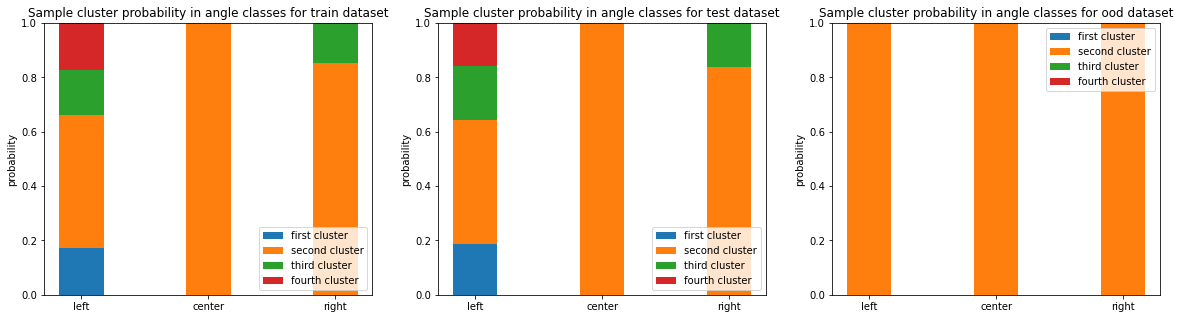

In [25]:
import pandas as pd
def get_probas(clazz, cluster_labels):
    df = pd.DataFrame(np.array([clazz,
                                cluster_labels,
                                np.ones(9500)
                                ]).T,
                      columns=['angle_class', 'cluster', 'counts'])
    df["angle_class"].replace({-1: 'left', 0: 'center', 1: 'right'}, inplace=True)
    df["cluster"].replace({0: 'first', 1: 'second', 2: 'third', 3: 'fourth'}, inplace=True)
    return df.groupby('angle_class').cluster.apply(lambda g: g.value_counts() / len(g))


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plot_ax(axs[0], get_probas(fast_clazz[:9500], train_labels), 'train')
plot_ax(axs[1], get_probas(fast_clazz[9500:9500+9500], test_labels), 'test')
plot_ax(axs[2], get_probas(slow_clazz[:9500], OOD_labels), 'ood')
plt.show()


# TSNE

In [19]:
from sklearn.manifold import TSNE
low_dim_train = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(fast_model_IND_train)


/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [20]:
low_dim_train.embedding_.shape

(9500, 3)

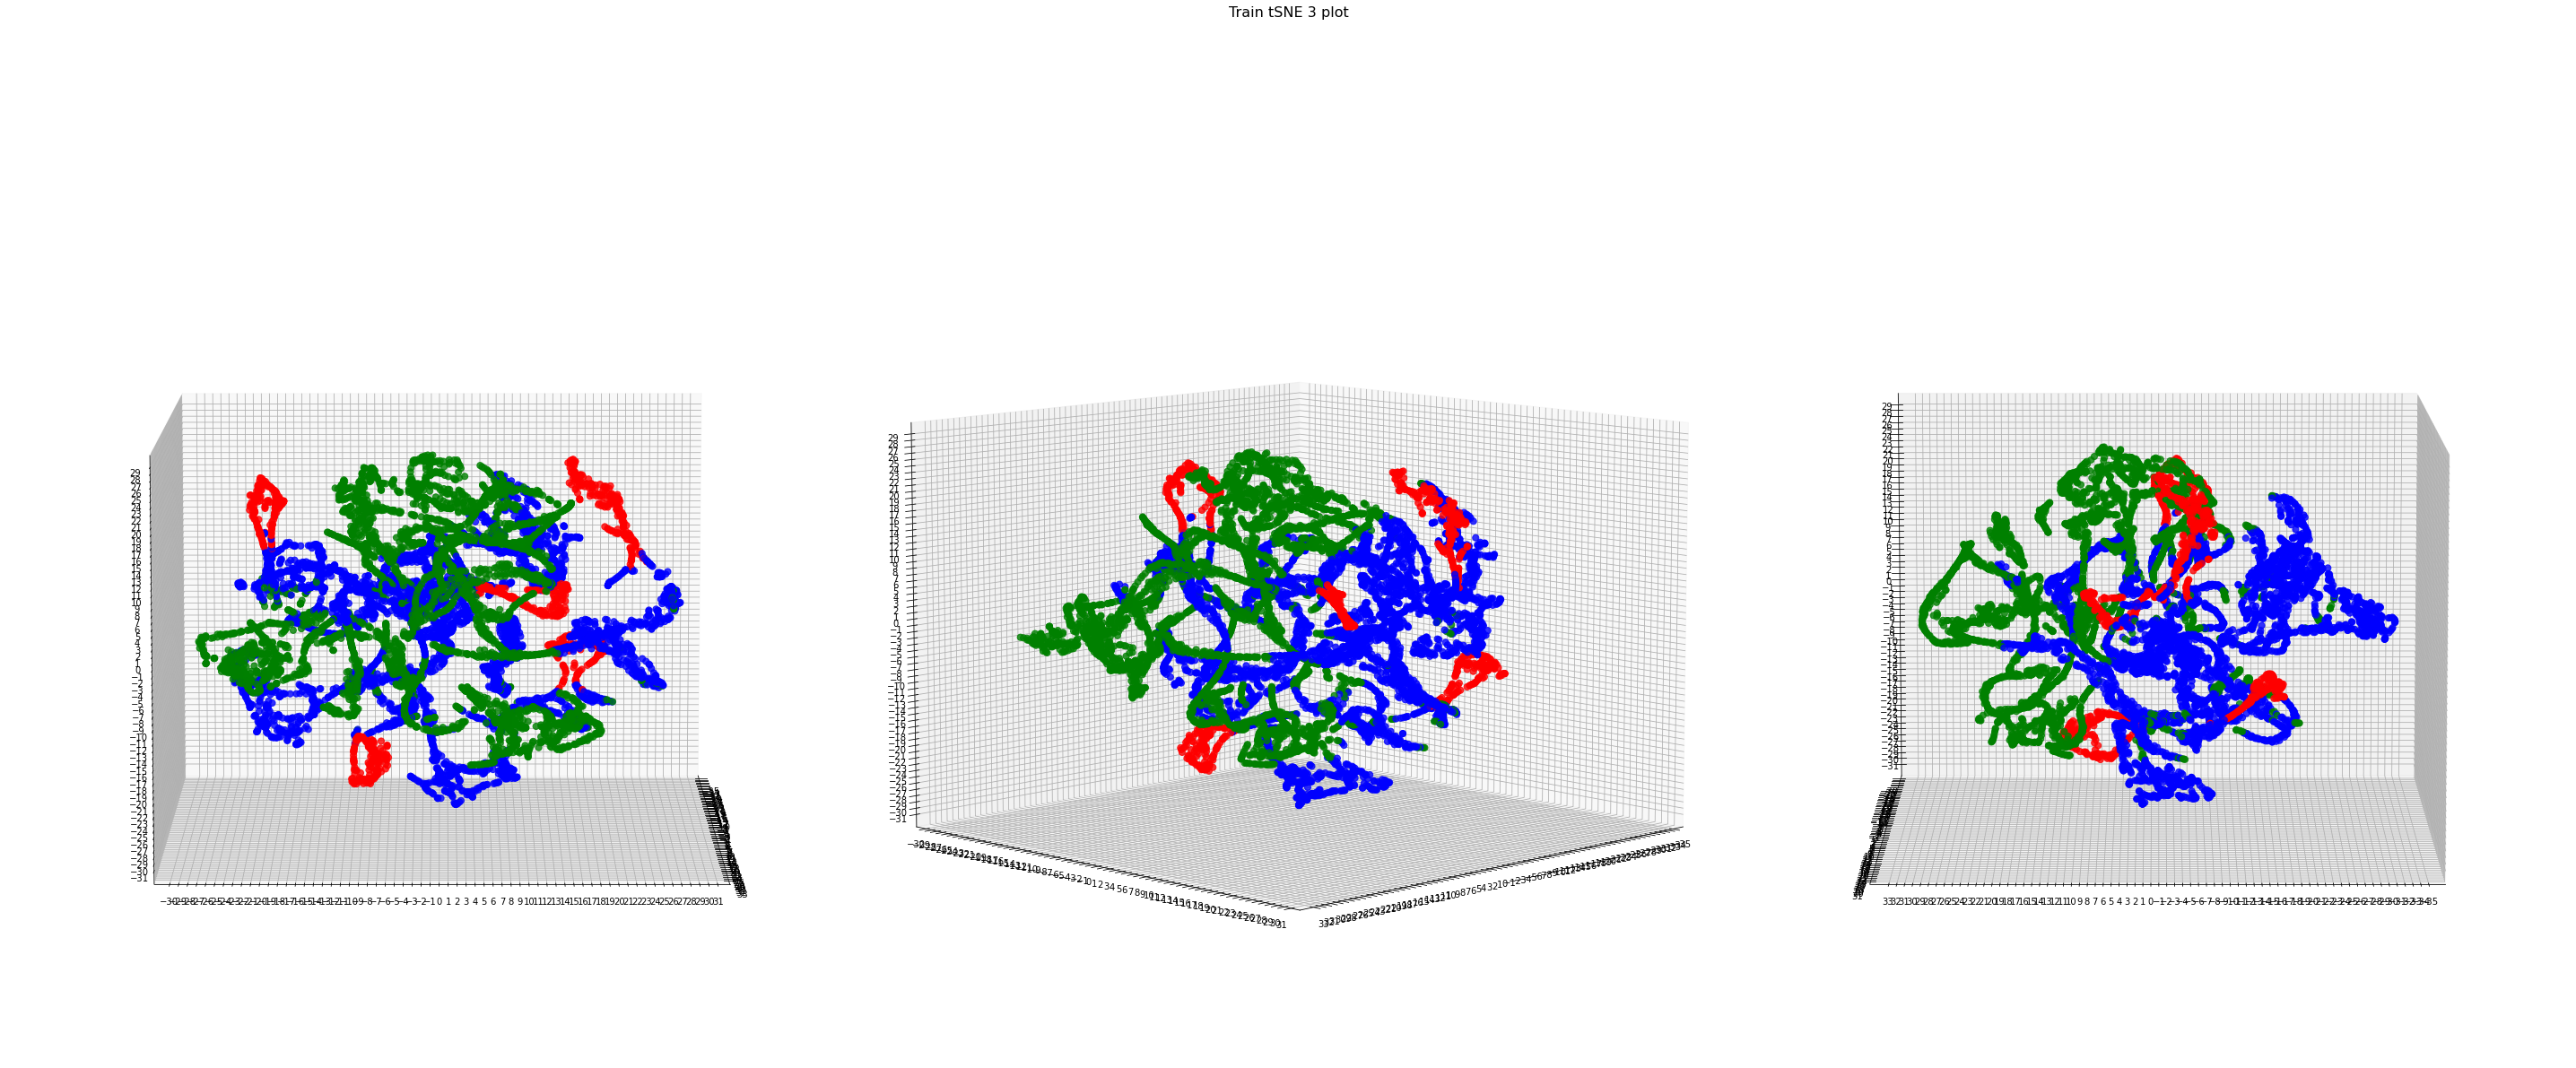

In [38]:
from matplotlib import ticker
import matplotlib

def plot_3d(points, points_color, title):

    x, y, z = points.T

    fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(40, 20),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = axs[0].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[0].view_init(azim=0, elev=9)
    axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[0].zaxis.set_major_locator(ticker.MultipleLocator(1))

    col = axs[1].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[1].view_init(azim=45, elev=9)
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1].zaxis.set_major_locator(ticker.MultipleLocator(1))

    col = axs[2].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[2].view_init(azim=90, elev=9)
    axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[2].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[2].zaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

plot_3d(low_dim_train.embedding_, fast_clazz[:9500], 'Train tSNE 3 plot')

In [40]:
low_dim_test = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(fast_model_IND_test)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


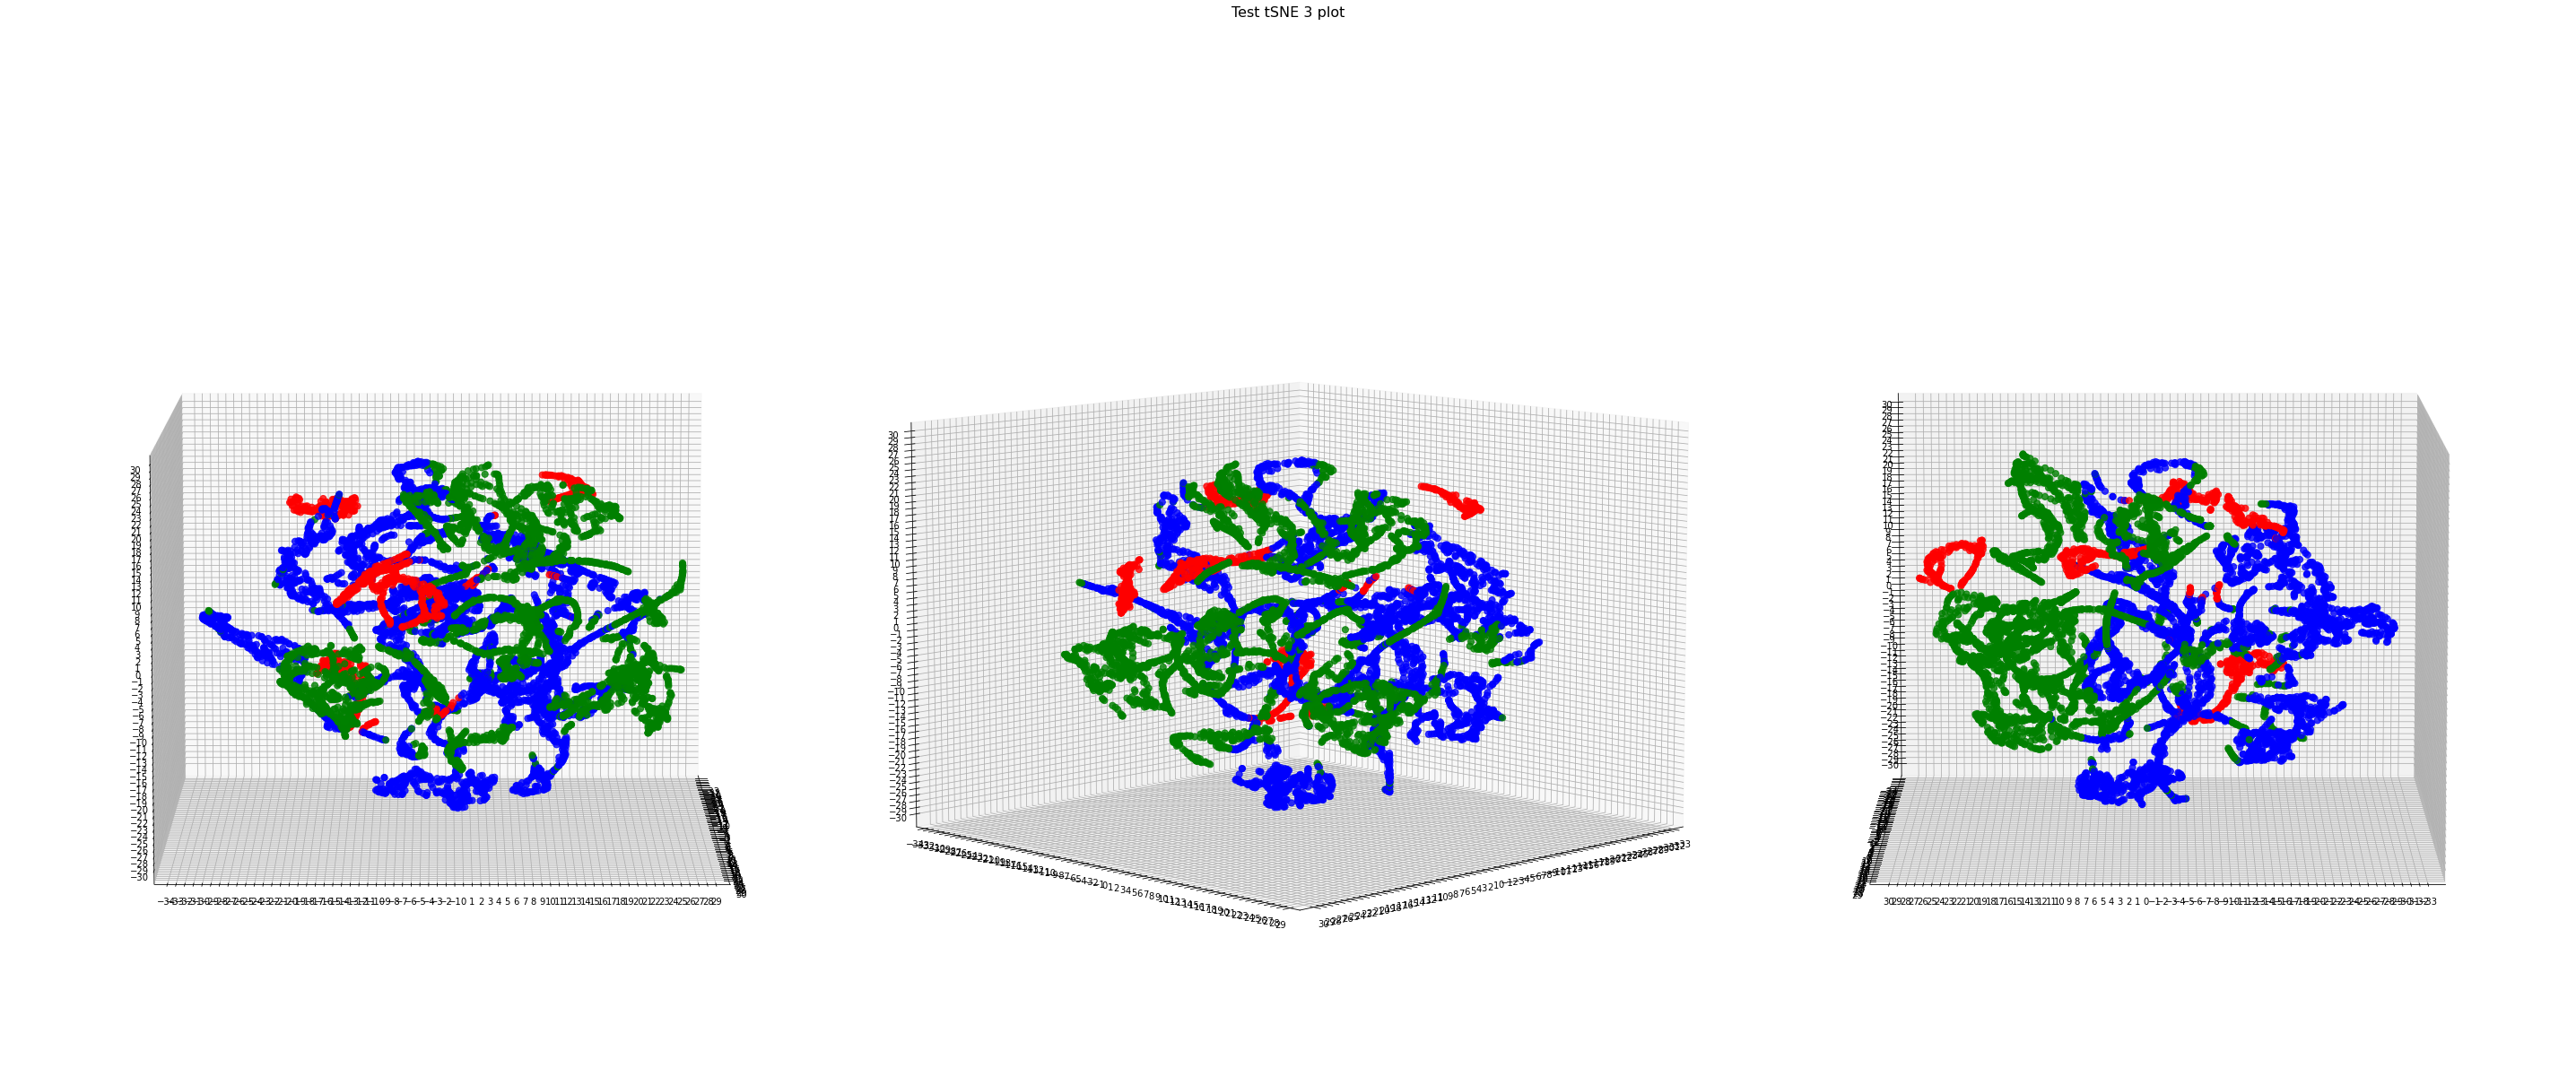

In [41]:
plot_3d(low_dim_test.embedding_, fast_clazz[9500:9500+9500], 'Test tSNE 3 plot')

In [42]:
low_dim_ood = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(fast_model_OOD)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


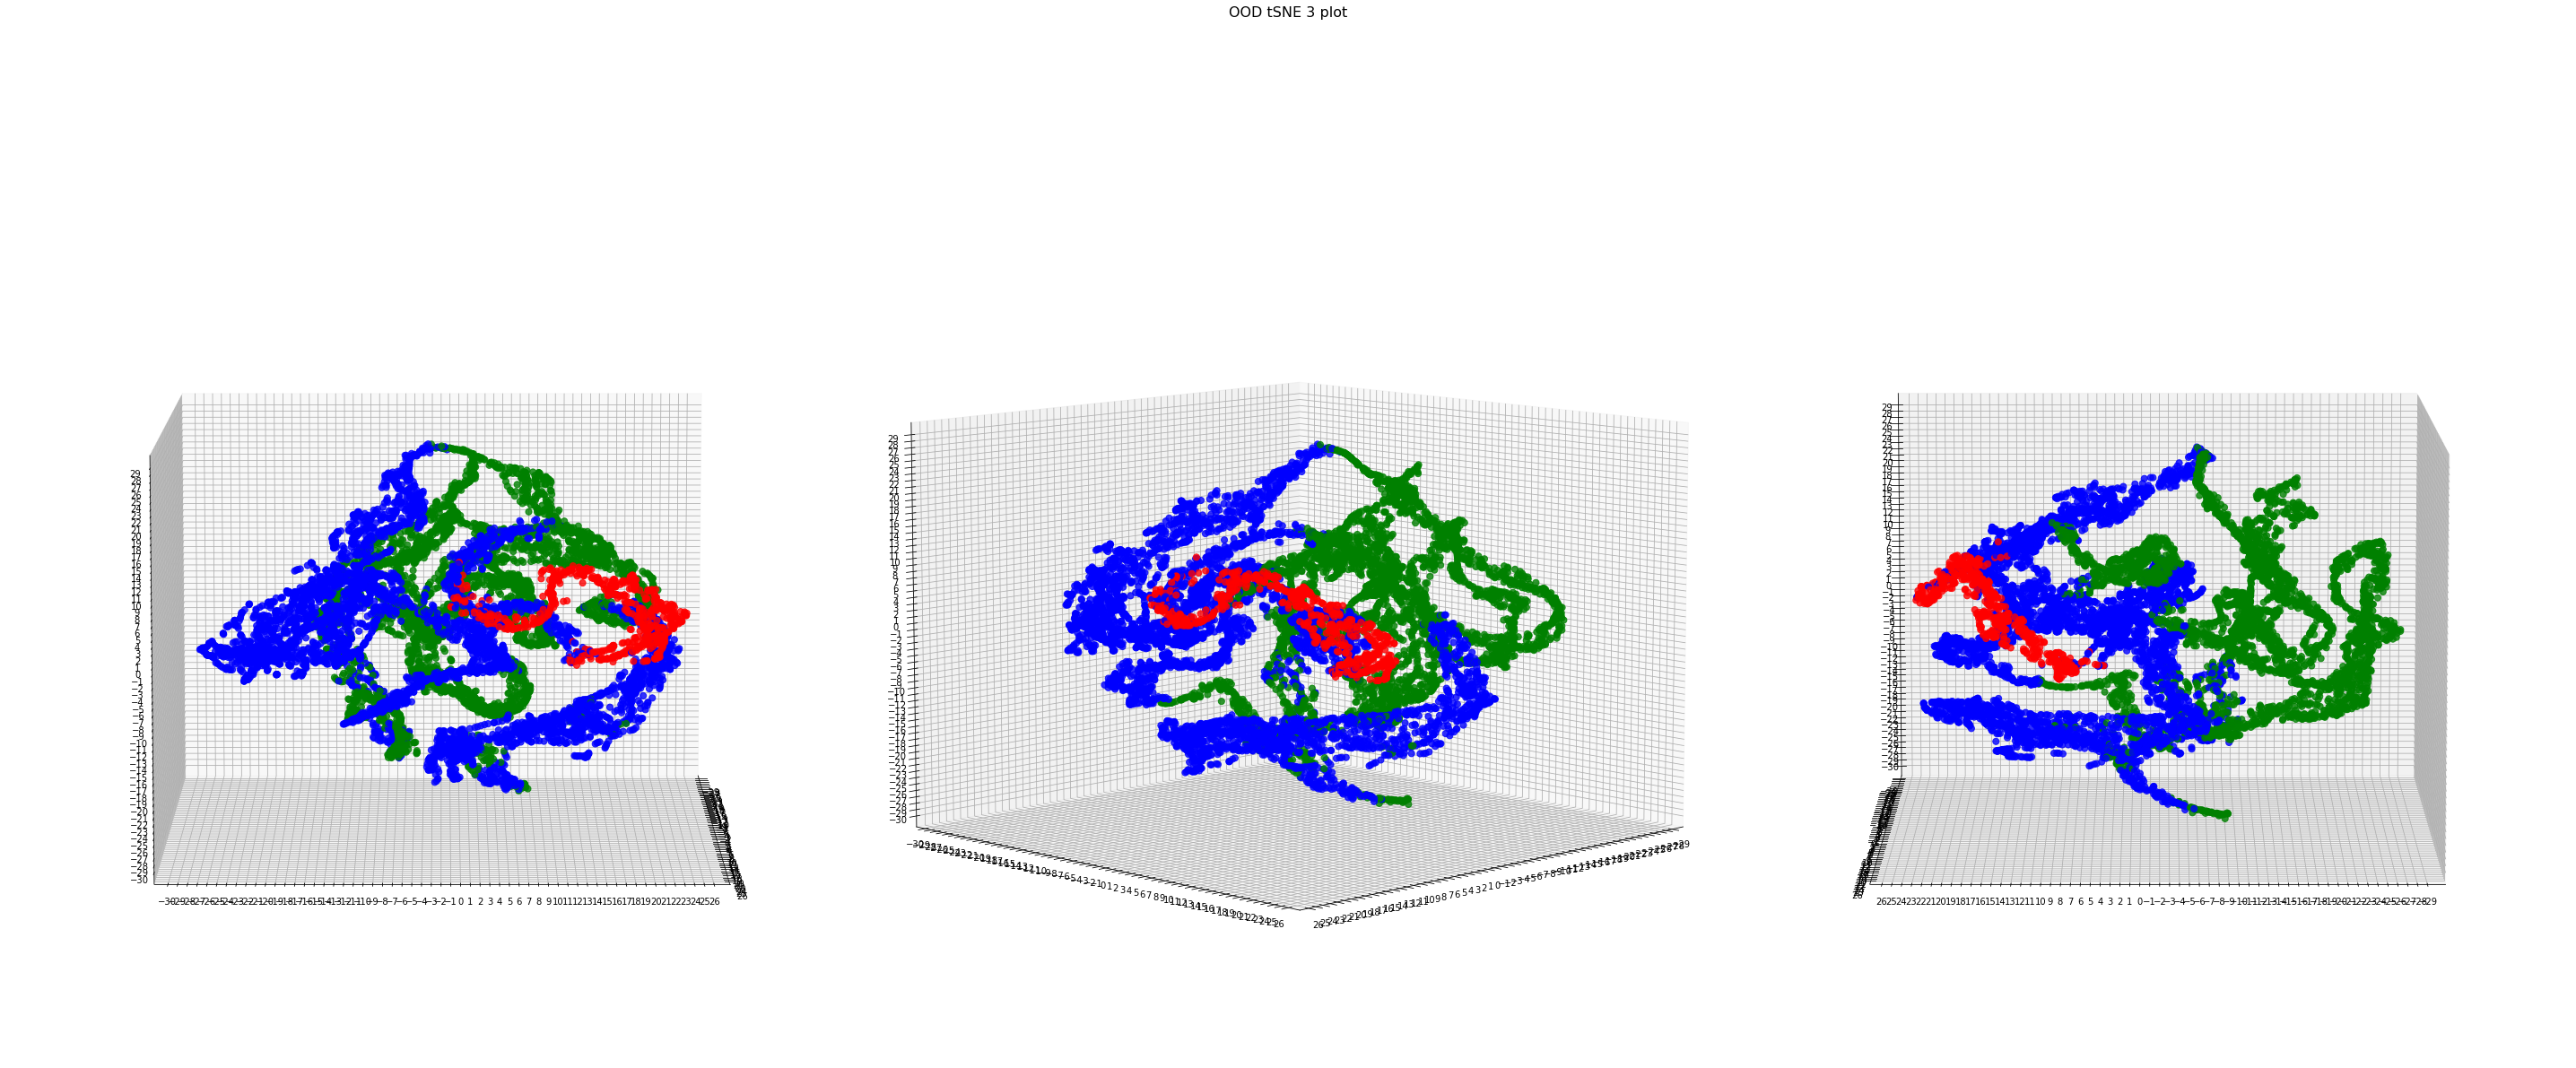

In [43]:

plot_3d(low_dim_ood.embedding_, slow_clazz[:9500], 'OOD tSNE 3 plot')